In [21]:
import numpy as np
import random
from collections import defaultdict
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [9]:

###############################################################################
#                      VARIABLES FOR EXPERIMENTATION
###############################################################################
# --- ENVIRONMENT SETTINGS ---
ENV_SIZE = (10, 10, 10)       # (x_size, y_size, z_size). Increase for a bigger 3D grid; 
                              # decreasing them makes for a smaller state space easier to debug.

OBSTACLES_COUNT = 15         # How many random obstacles to generate. 
                             # More obstacles => less open space, more challenge.

MINES_COUNT = 5              # Number of random mines. 
                             # Increases the risk of sudden negative rewards.

SLIP_P = 0.2                 # Probability of a random slip/portal event. 
                             # 0 => no slip, 1 => always slip. Higher makes environment more stochastic.

SLIP_MODE = "random"         # "random" => slip to a random free cell; 
                             # "fixed" => slip to a chosen 'portal_exit'.

PORTAL_EXIT = (0,0,0)        # Only matters if SLIP_MODE = 'fixed'. 
                             # The cell to which you teleport if slip occurs.

MOVING_OBSTACLES = True      # If True, obstacles shift each step (nonstationary environment). 
                             # Set to False to keep obstacles stationary.

STEP_PENALTY = -0.01         # Negative reward per step/time step. 
                             # Encourages faster solutions.

MINE_PENALTY = -10.0         # Negative reward for hitting a mine. 
                             # Increase magnitude to punish stepping on mines more severely.

START_STATE = (0,0,0)        # Where the agent starts
GOAL_STATE  = (9,9,9)        # The goal location in the 3D grid

# --- RL SETTINGS ---
GAMMA = 0.9                  # Discount factor for Value Iteration, MC, Q-learning 
THETA = 1e-3                 # Convergence threshold for Value Iteration
MAX_ITERS_VALUE_ITER = 60    # Max iterations for Value Iteration
SAMPLES_VALUE_ITER = 20      # Number of samples used to approximate p(s'|s,a) in Value Iteration

# Monte Carlo
MC_EPISODES = 4000           # Number of training episodes for the Monte Carlo approach
MC_EPSILON  = 0.15           # Epsilon-greedy factor for MC

# Q-Learning
QL_EPISODES   = 4000         # Number of training episodes for Q-learning
QL_ALPHA      = 0.1          # Learning rate
QL_EPSILON    = 0.15         # Epsilon-greedy factor
###############################################################################


In [10]:

###############################################################################
#                          FANCY 3D GRID ENVIRONMENT
###############################################################################
class Fancy3DGridEnv:
    """
    Fancy3DGridEnv 
    --------------
    3D environment with:
      - random/fixed obstacles,
      - random mines,
      - slip probability for portal teleports,
      - moving obstacles,
      - step penalties,
      - negative reward for mines,
      - single (start) -> single (goal).

    PRIMARY VARIABLES IN-USE:
      - x_size, y_size, z_size (ENV_SIZE)
      - obstacles_count, mines_count (or direct sets)
      - slip_p, slip_mode, portal_exit
      - moving_obstacles
      - step_penalty, mine_penalty
    """

    def __init__(
        self,
        x_size=10,
        y_size=10,
        z_size=10,
        start_state=(0,0,0),
        goal_state=(9,9,9),
        obstacles=None,
        mines=None,
        slip_p=0.2,
        slip_mode='random',
        portal_exit=(0,0,0),
        moving_obstacles=True,
        step_penalty=-0.01,
        mine_penalty=-10.0,
        obstacles_count=10,
        mines_count=5
    ):
        self.x_size = x_size
        self.y_size = y_size
        self.z_size = z_size
        
        self.start_state = start_state
        self.goal_state  = goal_state
        
        # If no obstacles specified, we randomly create obstacles_count of them
        if obstacles is None:
            obstacles = self._generate_random_obstacles(obstacles_count)
        self.obstacles = set(obstacles)
        
        # If no mines specified, create mines_count randomly
        if mines is None:
            mines = self._generate_random_mines(mines_count)
        self.mines = set(mines)
        
        self.slip_p      = slip_p
        self.slip_mode   = slip_mode
        self.portal_exit = portal_exit
        
        self.moving_obstacles = moving_obstacles
        self.step_penalty  = step_penalty
        self.mine_penalty  = mine_penalty
        
        # 6 possible actions in 3D
        # 0: x+1, 1: x-1, 2: y+1, 3: y-1, 4: z+1, 5: z-1
        self.actions = [0,1,2,3,4,5]
        
        self.time_step = 0  # for obstacle shifting

    def _generate_random_obstacles(self, count=10):
        """Generate 'count' random obstacle positions (excluding start/goal)."""
        obs = set()
        possible_cells = []
        for x in range(self.x_size):
            for y in range(self.y_size):
                for z in range(self.z_size):
                    if (x,y,z) not in [self.start_state, self.goal_state]:
                        possible_cells.append((x,y,z))
        random.shuffle(possible_cells)
        return set(possible_cells[:count])

    def _generate_random_mines(self, count=5):
        """Generate 'count' random mines (excluding start, goal, obstacles)."""
        mines = set()
        possible_cells = []
        for x in range(self.x_size):
            for y in range(self.y_size):
                for z in range(self.z_size):
                    if ((x,y,z) != self.start_state and
                        (x,y,z) != self.goal_state and
                        (x,y,z) not in self.obstacles):
                        possible_cells.append((x,y,z))
        random.shuffle(possible_cells)
        return set(possible_cells[:count])
    
    def reset(self):
        """Reset environment to start_state, time=0."""
        self.time_step = 0
        return self.start_state

    def step(self, state, action):
        """
        step(...)
        1) Move in 3D
        2) Bound/Obstacle check
        3) Slip check
        4) Mines or goal => rewards
        5) Possibly shift obstacles
        returns next_state, reward, done
        """
        (x, y, z) = state
        # Movement logic
        if action == 0:
            nx, ny, nz = x+1, y, z
        elif action == 1:
            nx, ny, nz = x-1, y, z
        elif action == 2:
            nx, ny, nz = x, y+1, z
        elif action == 3:
            nx, ny, nz = x, y-1, z
        elif action == 4:
            nx, ny, nz = x, y, z+1
        elif action == 5:
            nx, ny, nz = x, y, z-1
        else:
            nx, ny, nz = x, y, z

        # Bound check
        if not self._in_bounds(nx, ny, nz):
            nx, ny, nz = x, y, z
        # Obstacle check
        if (nx, ny, nz) in self.obstacles:
            nx, ny, nz = x, y, z
        
        next_state = (nx, ny, nz)
        
        # Slip / portal
        if random.random() < self.slip_p:
            if self.slip_mode == 'random':
                free_cells = []
                for xx in range(self.x_size):
                    for yy in range(self.y_size):
                        for zz in range(self.z_size):
                            if (xx,yy,zz) not in self.obstacles:
                                free_cells.append((xx,yy,zz))
                if free_cells:
                    next_state = random.choice(free_cells)
            else:  # 'fixed'
                next_state = self.portal_exit
        
        # Reward setup
        reward = self.step_penalty
        done   = False
        # Mine check
        if next_state in self.mines:
            reward += self.mine_penalty
            done = True
        # Goal check
        elif next_state == self.goal_state:
            reward += 1.0
            done = True
        
        # Move obstacles over time
        self.time_step += 1
        if self.moving_obstacles:
            self._update_obstacles()
        
        return next_state, reward, done

    def _in_bounds(self, x, y, z):
        return (0 <= x < self.x_size) and (0 <= y < self.y_size) and (0 <= z < self.z_size)

    def _update_obstacles(self):
        """
        Shift obstacles in +z each step (wrap around).
        """
        new_obs = set()
        for (ox, oy, oz) in self.obstacles:
            newz = oz + 1
            if newz >= self.z_size:
                newz = 0
            new_obs.add((ox, oy, newz))
        self.obstacles = new_obs


In [11]:

###############################################################################
#                          HELPER FOR VALUE ITERATION
###############################################################################
def simulate_step_once(env, s, a):
    """
    simulate_step_once
    ------------------
    This function replicates a single step without changing the real environment's 
    time or obstacles. It's used for approximate Value Iteration to sample transitions.
    """
    (x,y,z) = s
    if a == 0:
        nx, ny, nz = x+1, y, z
    elif a == 1:
        nx, ny, nz = x-1, y, z
    elif a == 2:
        nx, ny, nz = x, y+1, z
    elif a == 3:
        nx, ny, nz = x, y-1, z
    elif a == 4:
        nx, ny, nz = x, y, z+1
    elif a == 5:
        nx, ny, nz = x, y, z-1
    else:
        nx, ny, nz = x,y,z

    if not env._in_bounds(nx, ny, nz):
        nx, ny, nz = x, y, z

    if (nx, ny, nz) in env.obstacles:
        nx, ny, nz = x, y, z

    final_state = (nx, ny, nz)
    # slip check
    if random.random() < env.slip_p:
        if env.slip_mode == 'random':
            free_cells = []
            for xx in range(env.x_size):
                for yy in range(env.y_size):
                    for zz in range(env.z_size):
                        if (xx,yy,zz) not in env.obstacles:
                            free_cells.append((xx,yy,zz))
            if free_cells:
                final_state = random.choice(free_cells)
        else:
            final_state = env.portal_exit

    reward = env.step_penalty
    done = False
    if final_state in env.mines:
        reward += env.mine_penalty
        done = True
    elif final_state == env.goal_state:
        reward += 1.0
        done = True
    return final_state, reward, done



In [12]:
###############################################################################
#                            VALUE ITERATION 3D
###############################################################################
def value_iteration_3d(env, gamma=GAMMA, theta=THETA, max_iters=MAX_ITERS_VALUE_ITER, samples=SAMPLES_VALUE_ITER):
    """
    value_iteration_3d
    ------------------
    Approximate Value Iteration for a 3D environment that might be nonstationary. 
    We sample multiple times to estimate transitions for each (s,a).
    
    Variables to experiment with:
      - gamma: discount factor
      - theta: convergence threshold
      - max_iters: maximum iteration
      - samples: how many times we sample each (s,a) for approximate distribution
    """
    # Gather all states
    states = []
    for x in range(env.x_size):
        for y in range(env.y_size):
            for z in range(env.z_size):
                states.append((x,y,z))
    
    # Initialize V
    V = {}
    for s in states:
        V[s] = 0.0
    
    for iteration in range(max_iters):
        delta = 0.0
        for s in states:
            if s in env.obstacles or s in env.mines or s == env.goal_state:
                continue
            best_val = float('-inf')
            for a in env.actions:
                val_sum = 0.0
                for _ in range(samples):
                    ns, r, done = simulate_step_once(env, s, a)
                    val_sum += r + (gamma*V[ns] if not done else 0.0)
                avg_val = val_sum / samples
                if avg_val > best_val:
                    best_val = avg_val
            old_v = V[s]
            V[s] = best_val
            delta = max(delta, abs(best_val - old_v))
        if delta < theta:
            print(f"[ValueIteration3D] Converged at iteration={iteration} with delta={delta:.5f}")
            break
    
    # Derive policy
    policy = {}
    for s in states:
        if s in env.obstacles or s in env.mines or s == env.goal_state:
            policy[s] = None
            continue
        best_a = None
        best_val = float('-inf')
        for a in env.actions:
            val_sum = 0.0
            for _ in range(samples):
                ns, r, done = simulate_step_once(env, s, a)
                val_sum += r + (gamma*V[ns] if not done else 0.0)
            avg_val = val_sum / samples
            if avg_val > best_val:
                best_val = avg_val
                best_a = a
        policy[s] = best_a
    
    return V, policy

In [13]:
###############################################################################
#                            MONTE CARLO (ON-POLICY)
###############################################################################
def mc_control_3d(env, gamma=GAMMA, epsilon=MC_EPSILON, episodes=MC_EPISODES):
    """
    mc_control_3d
    -------------
    On-policy Monte Carlo with every-visit updates.

    Variables to experiment with:
      - gamma
      - epsilon
      - episodes
    """
    Q = defaultdict(lambda: np.zeros(len(env.actions)))
    returns_sum = defaultdict(lambda: np.zeros(len(env.actions)))
    returns_count = defaultdict(lambda: np.zeros(len(env.actions)))

    def epsilon_greedy(s):
        if s in env.obstacles or s in env.mines or s == env.goal_state:
            return 0  # trivial action if terminal or blocked
        if random.random() < epsilon:
            return random.choice(env.actions)
        else:
            return np.argmax(Q[s])
    
    for ep in range(episodes):
        episode = []
        s = env.reset()
        done = False
        while not done:
            a = epsilon_greedy(s)
            ns, r, done = env.step(s, a)
            episode.append((s,a,r))
            s = ns
        
        G = 0.0
        visited = set()
        for t in reversed(range(len(episode))):
            s_t, a_t, r_t = episode[t]
            G = gamma*G + r_t
            if (s_t,a_t) not in visited:
                visited.add((s_t,a_t))
                returns_sum[s_t][a_t] += G
                returns_count[s_t][a_t] += 1
                Q[s_t][a_t] = returns_sum[s_t][a_t]/returns_count[s_t][a_t]
    
    # Extract policy
    policy = {}
    for x in range(env.x_size):
        for y in range(env.y_size):
            for z in range(env.z_size):
                s = (x,y,z)
                if s in env.obstacles or s in env.mines or s == env.goal_state:
                    policy[s] = None
                else:
                    policy[s] = np.argmax(Q[s])
    return Q, policy

In [14]:
###############################################################################
#                            Q-LEARNING (TD)
###############################################################################
def q_learning_3d(env, alpha=QL_ALPHA, gamma=GAMMA, epsilon=QL_EPSILON, episodes=QL_EPISODES):
    """
    q_learning_3d
    -------------
    Off-policy TD method to learn Q in a 3D environment.

    Variables to experiment with:
      - alpha (learning rate)
      - gamma (discount)
      - epsilon (exploration)
      - episodes (# training episodes)
    """
    Q = defaultdict(lambda: np.zeros(len(env.actions)))

    def epsilon_greedy(s):
        if s in env.obstacles or s in env.mines or s == env.goal_state:
            return 0
        if random.random() < epsilon:
            return random.choice(env.actions)
        else:
            return np.argmax(Q[s])
    
    for ep in range(episodes):
        s = env.reset()
        done = False
        while not done:
            a = epsilon_greedy(s)
            ns, r, done = env.step(s, a)
            best_next_a = 0
            if (ns not in env.obstacles) and (ns not in env.mines) and (ns != env.goal_state):
                best_next_a = np.argmax(Q[ns])
            
            Q[s][a] += alpha * (r + gamma*Q[ns][best_next_a] - Q[s][a])
            s = ns
    
    # Policy derivation
    policy = {}
    for x in range(env.x_size):
        for y in range(env.y_size):
            for z in range(env.z_size):
                s = (x,y,z)
                if s in env.obstacles or s in env.mines or s == env.goal_state:
                    policy[s] = None
                else:
                    policy[s] = np.argmax(Q[s])
    return Q, policy


In [ ]:
###############################################################################
#                               MAIN SIMULATION
###############################################################################
if __name__ == "__main__":
    """
    SIMULATION:
    -----------
    When you run this script, it will:

    1) Create a 3D environment with your project-specific variables set at 
       the top of this file (ENV_SIZE, OBSTACLES_COUNT, MINES_COUNT, etc.)
    2) Perform Value Iteration (approx) and print sample results
    3) Perform Monte Carlo Control for MC_EPISODES episodes, then print 
       a sample policy action at start state
    4) Perform Q-Learning for QL_EPISODES episodes, then also print a sample 
       policy action at start state

    This demonstrates the final code for your project. 
    Modify the "VARIABLES FOR EXPERIMENTATION" section 
    to see how performance or behavior changes.
    """
    x_sz, y_sz, z_sz = ENV_SIZE
    env_3d = Fancy3DGridEnv(
        x_size=x_sz,
        y_size=y_sz,
        z_size=z_sz,
        start_state=START_STATE,
        goal_state=GOAL_STATE,
        obstacles=None,   # random obstacles_count
        mines=None,       # random mines_count
        slip_p=SLIP_P,
        slip_mode=SLIP_MODE,
        portal_exit=PORTAL_EXIT,
        moving_obstacles=MOVING_OBSTACLES,
        step_penalty=STEP_PENALTY,
        mine_penalty=MINE_PENALTY,
        obstacles_count=OBSTACLES_COUNT,
        mines_count=MINES_COUNT
    )

    # Print out the environment settings
    print("\n--- Running final 3D project code with the following parameters ---")
    print(f"ENV_SIZE={ENV_SIZE}, Start={START_STATE}, Goal={GOAL_STATE}")
    print(f"OBSTACLES_COUNT={OBSTACLES_COUNT}, MINES_COUNT={MINES_COUNT}")
    print(f"SLIP_P={SLIP_P}, SLIP_MODE={SLIP_MODE}")
    print(f"MOVING_OBSTACLES={MOVING_OBSTACLES}, STEP_PENALTY={STEP_PENALTY}, MINE_PENALTY={MINE_PENALTY}")
    print(f"Value Iteration => max_iters={MAX_ITERS_VALUE_ITER}, samples={SAMPLES_VALUE_ITER}")
    print(f"MonteCarlo => episodes={MC_EPISODES}, epsilon={MC_EPSILON}")
    print(f"Q-Learning => episodes={QL_EPISODES}, alpha={QL_ALPHA}, epsilon={QL_EPSILON}")
    print("-----------------------------------------------------------------\n")

    # 1) Value Iteration
    print("=== Value Iteration (Approx) ===")
    V_3d, pi_3d = value_iteration_3d(
        env_3d,
        gamma=GAMMA,
        theta=THETA,
        max_iters=MAX_ITERS_VALUE_ITER,
        samples=SAMPLES_VALUE_ITER
    )
    # Sample states
    sample_check = [START_STATE, (1,1,1), GOAL_STATE]
    for st in sample_check:
        print(f"State {st}: Value={round(V_3d[st],3)}, Policy={pi_3d[st]}")

    # 2) Monte Carlo
    print("\n=== Monte Carlo (On-Policy) ===")
    Q_mc, pi_mc = mc_control_3d(env_3d, gamma=GAMMA, epsilon=MC_EPSILON, episodes=MC_EPISODES)
    print(f"Sample policy at start state {START_STATE} => {pi_mc.get(START_STATE)}")

    # 3) Q-Learning
    print("\n=== Q-Learning ===")
    Q_q, pi_q = q_learning_3d(env_3d, alpha=QL_ALPHA, gamma=GAMMA, epsilon=QL_EPSILON, episodes=QL_EPISODES)
    print(f"Sample policy at start state {START_STATE} => {pi_q.get(START_STATE)}")

    print("\nFinished")



--- Running final 3D project code with the following parameters ---
ENV_SIZE=(10, 10, 10), Start=(0, 0, 0), Goal=(9, 9, 9)
OBSTACLES_COUNT=15, MINES_COUNT=5
SLIP_P=0.2, SLIP_MODE=random
MOVING_OBSTACLES=True, STEP_PENALTY=-0.01, MINE_PENALTY=-10.0
Value Iteration => max_iters=60, samples=20
MonteCarlo => episodes=4000, epsilon=0.15
Q-Learning => episodes=4000, alpha=0.1, epsilon=0.15
-----------------------------------------------------------------

=== Value Iteration (Approx) ===


State (0, 0, 0): Value=0.092, Policy=4
State (1, 1, 1): Value=0.119, Policy=2
State (9, 9, 9): Value=0.0, Policy=None

=== Monte Carlo (On-Policy) ===
Sample policy at start state (0, 0, 0) => 2

=== Q-Learning ===
Sample policy at start state (0, 0, 0) => 5

DONE. You can now analyze the final code and experiment with the top-level variables.


In [ ]:
#Data Collection

import csv
import random

def run_simulation_and_log_data(env, episodes, output_csv, algorithm):
    with open(output_csv, mode="a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["algorithm", "episode", "time_step", "state", "action", "reward", "next_state", "done"])
        for ep in range(episodes):
            state = env.reset()
            done = False
            time_step = 0
            while not done:
                action = random.choice(env.actions)
                next_state, reward, done = env.step(state, action)
                writer.writerow({
                    "algorithm": algorithm,
                    "episode": ep,
                    "time_step": time_step,
                    "state": state,
                    "action": action,
                    "reward": reward,
                    "next_state": next_state,
                    "done": done
                })
                state = next_state
                time_step += 1

if __name__ == "__main__":
    output_csv = "simulation_data.csv"
    with open(output_csv, mode="w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["algorithm", "episode", "time_step", "state", "action", "reward", "next_state", "done"])
        writer.writeheader()
    env = Fancy3DGridEnv(
        x_size=10,
        y_size=10,
        z_size=10,
        start_state=(0,0,0),
        goal_state=(9,9,9),
        obstacles=None, # Random generation
        mines=None, # ^
        slip_p=0.2,
        slip_mode="random",
        portal_exit=(0,0,0),
        moving_obstacles=True,
        step_penalty=-0.01,
        mine_penalty=-10.0,
        obstacles_count=15,
        mines_count=5
    )
    for alg in ["TD Learning", "Q Learning", "Monte Carlo"]:
        run_simulation_and_log_data(env, 1000, output_csv, alg)


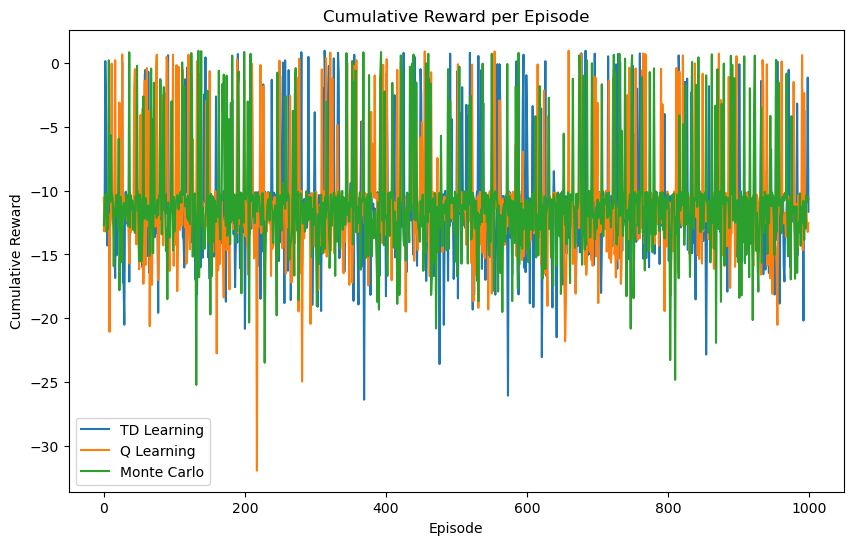

In [28]:
def load_cumulative_rewards(csv_file, algorithm_filter=None):
    df = pd.read_csv(csv_file)
    if algorithm_filter:
        df = df[df["algorithm"] == algorithm_filter]
    return df.groupby("episode")["reward"].sum()

algorithms = ["TD Learning", "Q Learning", "Monte Carlo"]
plt.figure(figsize=(10,6))
for alg in algorithms:
    rewards = load_cumulative_rewards("simulation_data.csv", algorithm_filter=alg)
    plt.plot(rewards.index, rewards.values, label=alg)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward per Episode")
plt.legend()
plt.show()

In [30]:
def compute_success_rate(csv_file, algorithm_filter=None):
    df = pd.read_csv(csv_file)
    if algorithm_filter:
        df = df[df["algorithm"] == algorithm_filter]
    final_steps = df[df["done"] == True].groupby("episode").last()
    successes = final_steps[final_steps["reward"] > 0].shape[0]
    total = final_steps.shape[0]
    return successes / total if total > 0 else 0

for alg in algorithms:
    success_rate = compute_success_rate("simulation_data.csv", algorithm_filter=alg)
    print(f"Success rate for {alg}: {success_rate*100:.2f}%")


Success rate for TD Learning: 10.90%
Success rate for Q Learning: 10.50%
Success rate for Monte Carlo: 12.30%


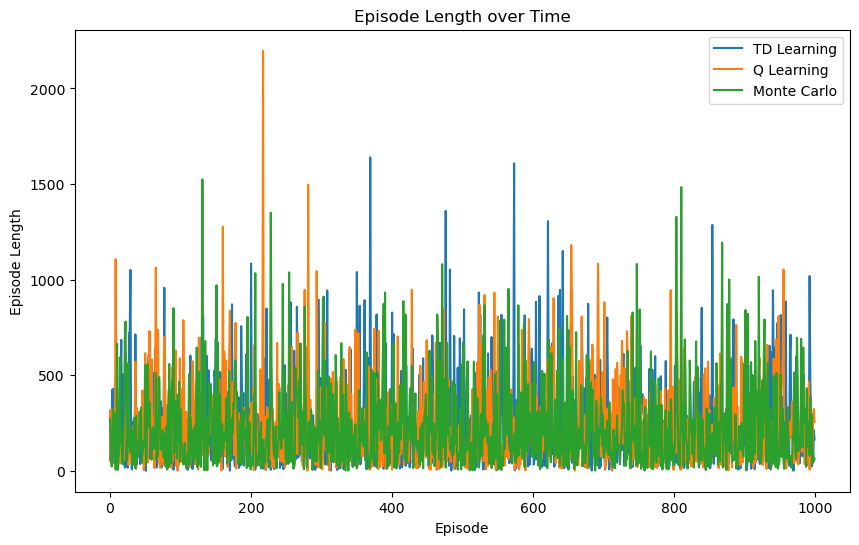

In [ ]:
def load_episode_lengths(csv_file, algorithm_filter=None):
    df = pd.read_csv(csv_file)
    if algorithm_filter:
        df = df[df["algorithm"] == algorithm_filter]
    lengths = df.groupby("episode")["time_step"].max() + 1
    return lengths

plt.figure(figsize=(10,6))
for alg in algorithms:
    lengths = load_episode_lengths("simulation_data.csv", algorithm_filter=alg)
    plt.plot(lengths.index, lengths.values, label=alg)
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")
plt.legend()
plt.show()
